Here are a few things to note about Langgraph before we make gthe deepdive in this workshop:

1. Langgraph is a framework for building **complex, stateful LLM agent** and multi-agent applications. 

2. Langgraph uses a graph-based architecture that guves developers **fine-grained** control over the agents behaviour.

3. It's ideal for creating **robust, production-ready AI systems** that require **precision** and **adaptability**.


Stateful means that it treats these graphs to have states meaning that they have instances per time that relates to their current configurations and also adjusts over time.


Langgraph models agents workflows using three main components:

1. **State**: A shared data structure that tracks the current status of your app (workflow).

2. **Nodes**: Python functions that defines the agents behaviour. They take in the current state, perform actions, and return the updated state.

3. **Edges**: Pythomn function that defines which nodes runs next based on the state, allowing for conditional or fixed transitions.

Let's make a deep dive now!!!

In [1]:
## Start by defining the state of the graph
## Note: The state schema serves as the input structure for both the node
## and the edges 

from typing_extensions import TypedDict

class State(TypedDict):
    graph_state: str

Since the state includes the `graph_state` this means thata every node that is created has the ability to access the `graph_state`. It is also note worthy that each node returns an updated value of the `graph_state`, and, by default this new value will overwrite the already existing one.

In [2]:
## We define the Nodes
## Note: Each node takes in the state schema as its first positional argument

def node_1(state):
    print("---Node 1---")
    return {"graph_state": state["graph_state"] + " Welcome"}

def node_2(state):
    print("---Node 2---")
    return {"graph_state": state["graph_state"] + " to the DataHack summit"}

def node_3(state):
    print("---Node 3---")
    return {"graph_state": state["graph_state"] + " to Lagos, Nigeria!"}

In [3]:
## We create the Edges
## Edges can be either normal or conditional. 
## Normal edges are used when you always want to transition from one node to another/
## example: from node_1 to node_2
## Conditional edges allows for dynamic routing based on logic. These are
## implemented as functions that evaluates the current state and return the 
## current state and the next node to execute

import random
from typing import Literal

def decide_node(state) -> Literal["node_2", "node_3"]:

    user_input = state["graph_state"]

    if random.random() < 0.5:
        return "node_2"
    return "node_3"

## The Graph Construction

Let's build the graph with the components that we have predefined.
We'll use the `StateGraph` class to create the graph structure.
First, initilaize a `StateGraph` with the `state` schema we defined earlier.
Then, add your nodes and then connect them with the edges.
Use the special `START` node to define the entry point of the graph-- This is where the user input enters the system.
The `END` node marks the terminal point where the agent finishes its execution.
Once all nodes and graphs are added, complile the nodes and the edges to validate its structure.
You can also visualize what is created as a mermaid diagram for clearer view of the workflow.

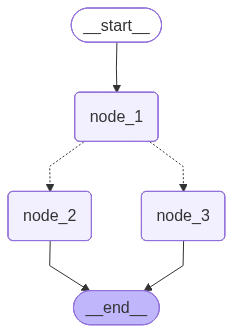

In [4]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

#Build the graph
builder = StateGraph(State)

#Defining the nodes
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

#Logic - Defining the edges
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_node)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

#Compile the Graph
graph = builder.compile()

#View
display(Image(graph.get_graph().draw_mermaid_png()))

## Graph Execution

The compiled graph comforms to the Runnable protocol which defines a staandard iunterface for executing Langcahin components.
You start by passing an input dictionary, such as {"graph_state": "Hi, there it is Chukwuma"}, to set the initial value of the graph state.
When the `.invoke()` is called execution begins from the `START` node.
The graph then proceeds through the defined nodes (node_, node_2, node_3), following the structure you built.
A conditional edge determines whether the flow goes from node_1 to node_2 or node_3, based on the 50/50 logic split.
Each node receives the current state, processes it and returns and updated value which replaces the previous graph_state.
Execution continues along the graph until it gets to the END dummy node, signaling completion.

In [5]:
graph.invoke({"graph_state": "Hi there, I am Chukwuma!"})

---Node 1---
---Node 2---


{'graph_state': 'Hi there, I am Chukwuma! Welcome to the DataHack summit'}

## Building LLM Applications with Langgraph

We recall that according to Langgraph there are 6 levels of autonomy from code to autonomous agents. Now, we're going to just start implementing the chains then routers and then we'll add cycles to our workflows. Thus, ending at the level of the state machines.

Let us explain these levels of autonomy as they relateto the things that we will be doing here:

1. **Code-only**: Fully hard-coded workflows with no AI based decisions.The user of the apploication defines every step of the application explicitly.

2. **LLM call**: The system involves one main large language call, often with pre- or post- processing. Simple chatbots generally falls into this category.

3. **Chain of LLM calls**: Multiple steps are sequenxced together in a fixed predefined control flow, such as in many basic retrieval augmented generation (RAG) application pipelines.

4. **Router**: The LLM is given the ability to make the decision on which function to take next, introducing a degree of flexibility and predictability into the flow.

5. **State Machine**: this combines routing capabilities with the ability to loop (cycles back to previous steps). This makes the execution even more dynamic, as the number of steps is not fixed and can iterate indefinitely until a goal is met or a condition is satisfied (e.g., self correction loops). This is the level where Langgraph's core functionality is often best applied.

6. **Autonomous Agents**: The higehst level, where the system itself decides what actions and steps are needed, potentially adapting iuts own prompts or even creating new tools. This level is largely considerd research-only at the moment due to its unpredictability and risk.

Let's build a simple chain that combines 4 concepts:

1. Using chat messages as our graph state
2. Using chat models in chat nodes
3. Binding tools to our chat models
4. Executing tool calls in graph nodes

Now, let's get into the basics about `Messages`.

Chat models can handle different types of messages representing various roles in a conversation. Langchain supports key message types like:

 1. `HumanMessage` - from the user
 2. `AIMesssage` - from the chat model
 3. `SystemMessage` - to guide the model's behaviour
 4. `ToolMessage` - responses from tool calls

Let's build a list of messages. Each message can include:
 1. **content**: the message text
 2. **name**: optional author name
 3. **response_metadata**: optional metadata (e.g. from model providers from AIMessage, like Gemini)


In [19]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

messages = [SystemMessage(content="You are a helpful travel assistant for Lagos, Nigeria. Provide detailed and engaging recommendations.")]
messages.append(AIMessage(content="Hello, i am your virtual travel assistant for Lagos, Nigeria. How can I help you plan your visit", name="Agent"))
messages.append(HumanMessage(content="I am visiting Lagos, Nigeria for the first time. Can you suggest key places to see?", name="Chukwuma"))
messages.append(AIMessage(content="Certainly, some must visit places include the Ikeja city Mall, the slave trade zones in Badagry and the Eko Atlantic ocean", name="Agent"))
messages.append(HumanMessage(content="I'm interested in a mix of history and the party life", name="Chukwuma"))
messages.append(AIMessage(content="Great choice there, you can explore Lekki-Ajah beach and the Museum in Badagry to see the slave trade and cultural heritage of the golden slave trade era", name="Agent"))

for m in messages:
    m.pretty_print()

================================ System Message ================================

You are a helpful travel assistant for Lagos, Nigeria. Provide detailed and engaging recommendations.
================================== Ai Message ==================================
Name: Agent

Hello, i am your virtual travel assistant for Lagos, Nigeria. How can I help you plan your visit
================================ Human Message =================================
Name: Chukwuma

I am visiting Lagos, Nigeria for the first time. Can you suggest key places to see?
================================== Ai Message ==================================
Name: Agent

Certainly, some must visit places include the Ikeja city Mall, the slave trade zones in Badagry and the Eko Atlantic ocean
================================ Human Message =================================
Name: Chukwuma

I'm interested in a mix of history and the party life
================================== Ai Message ==============================

## Chat Models

Chat models accept a sequence of messages as input and support multiple message types, as previously mentioned.
Among the available options, we'll be working with **GOOGLE_API**.
First, check your `GEMINI_API_KEY` if it is properly placed first

In [8]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GEMINI_API_KEY")

In [ ]:
# put in the right API key
del os.environ["GEMINI_API_KEY"]
_set_env("GEMINI_API_KEY")

In [21]:
#print(os.environ.get("GEMINI_API_KEY"))

In [22]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", api_key=os.environ["GEMINI_API_KEY"])

# Use it to generate responses
response = llm.invoke(messages)

In [23]:
response.pretty_print()

================================== Ai Message ==================================

. You can also visit the New Afrika Shrine to experience the Lagos nightlife and local delicacies.


In [24]:
print(f"Type: {type(response)}")

Type: <class 'langchain_core.messages.ai.AIMessage'>


In [25]:
response.content

'. You can also visit the New Afrika Shrine to experience the Lagos nightlife and local delicacies.'

In [26]:
response.pretty_print()

================================== Ai Message ==================================

. You can also visit the New Afrika Shrine to experience the Lagos nightlife and local delicacies.


## Tools

Tools are valuabkle when you need a model to interact with external systems.
These systems (such as APIs) typically expect structured inputs rather than natural language.

The model decides when to call a tool based on the user's natural language input , and the output will follow the tool's defined schema.
Many LLM providers now support tool calling, and LangChain offers a straightforward interface for it.
You can bind any Python function using **`ChatModel.bind_tools(function)`**.

Let's see a simple implementation of the tool, another further dive into the sea of Laanggraph.

In [27]:
def multiply(a: int, b: int) -> int:
    """
    Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools = llm.bind_tools([multiply])

In [28]:
no_tool_call = llm_with_tools.invoke(
    [HumanMessage(content = "Hey! How are you doing today?", name="Chukwuma")]
)

In [29]:
no_tool_call.pretty_print()

================================== Ai Message ==================================

I'm doing well, thank you! I'm ready to assist you. What can I do for you today?


In [30]:
tool_call = llm_with_tools.invoke(
    [HumanMessage(content="What is 7 multiplied y 21?", name="Chukwuma")]
)

tool_call.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiply (df688822-251f-4366-86b1-a63fec5d0279)
 Call ID: df688822-251f-4366-86b1-a63fec5d0279
  Args:
    a: 7
    b: 21


Note that whern a tool is called the response is always the argument of the tools been used and not the answer itself. Like, the example cof the above, we can see thatg the result is the not necessarily displayed but the arguments that are called from the tool.

In [31]:
tool_call.tool_calls

[{'name': 'multiply',
  'args': {'a': 7, 'b': 21},
  'id': 'df688822-251f-4366-86b1-a63fec5d0279',
  'type': 'tool_call'}]

## Defining ther state

We will be improving the state that we already created.
Unlike the example graph that we used before, we will be creating a state and this time we would be including the `messages` into this state. Ifwe needed to handle this manually then we would need to create another `TypedDict` with a messages property.

In [32]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

Fortunately, langgraph already provides a built-in state type for this `MessagesState`.
One cool thing about this is that it already includes the reducer that takes care of the appending of the new message to the message list.

It's like they observed that lots of people had to frequently do the above and that processes was too repetitive so they just had to implement it themselves.

In [33]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    pass

## Building The Graph

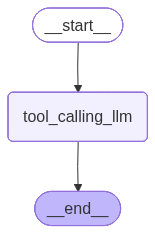

In [34]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

## Node
def tool_calling_llm(state: MessagesState):
    return {"messages": llm_with_tools.invoke(state["messages"])}

## Build Graph
builder = StateGraph(MessagesState)

builder.add_node("tool_calling_llm", tool_calling_llm)

builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)

graph = builder.compile()

# view
display(Image(graph.get_graph().draw_mermaid_png()))

We've implemented a very simple chain!
If we pass a general message (unrelated to Maths operations), the LLm will respond without any tool call.

In [35]:
messages = graph.invoke({"messages": HumanMessage(content="Hey! I am Chukwuma")})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hey! I am Chukwuma
================================== Ai Message ==================================

Hello Chukwuma! It's nice to meet you. How can I assist you today?


In [36]:
## Let's ask for a multiplication 
messages = graph.invoke({"messages": HumanMessage(content="What is the value of 4 multiplied by 6?")})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is the value of 4 multiplied by 6?
================================== Ai Message ==================================
Tool Calls:
  multiply (f779a815-883c-41e9-880b-91092ab65096)
 Call ID: f779a815-883c-41e9-880b-91092ab65096
  Args:
    b: 6
    a: 4
